In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

import xgboost 
from sklearn import set_config
set_config(transform_output="pandas")
pd.set_option('display.max_columns', 500)

In [2]:
from db.database_mysql import engine

df = pd.read_sql_query('''SELECT jp.raw_title, 
        YEAR(jp.date) AS year, 
        MONTH(jp.date) AS month, 
        DAY(jp.date) AS day, 
        im.director, im.date,im.casting, im.distributor, im.genre, jp.country, jp.duration, jp.first_day, jp.first_week, jp.first_weekend, jp.hebdo_rank, 
jp.total_spectator, jp.copies, im.rating_press, im.budget, im.lang, im.award 
FROM films_jp as jp
LEFT JOIN films_imdb im ON im.id_jp = jp.id 
where im.id_jp is not null and im.date = jp.date
order by jp.first_week desc''', engine)

# CREATION DES SCORES

In [3]:
import json
from modelisation.functions import *

clone = df.copy()
# calculate_director_scores(clone)
# calculate_distributor_scores(clone)
# calculate_actor_scores(clone)
calculate_year_scores(clone)
calculate_country_scores(clone)

print()

In [4]:
from modelisation.functions import *

entree_transformer = FunctionTransformer(classify_entrees_year, kw_args={'column' : 'year'})
season_transformer = FunctionTransformer(classify_season,  kw_args={'column' : 'month'})
month_transformer = FunctionTransformer(classify_month_name,  kw_args={'column' : 'month'})
holiday_transformer = FunctionTransformer(is_holiday)

pipe_scores = Pipeline([
  ('season_dict' , make_pipeline(season_transformer)),
  ('entree_dict' , make_pipeline(entree_transformer)),
  ('month_dict' , make_pipeline(month_transformer)),
  ('holiday_dict' , make_pipeline(holiday_transformer)),
])

# scores = df.copy()
# scores = pipe_scores.fit_transform(scores)
# scores.head(1)

# MODELE

In [5]:
# film = pd.read_sql_query('''SELECT 
#                               YEAR(date) AS year, 
#                               MONTH(date) AS month, 
#                               DAY(date) AS day, 
#                               director, distributor, casting, copies, duration, country
#                             FROM functionalities_filmscrap
#                             LIMIT 1
#                          ''', engine)
# film

In [6]:
from modelisation.converter import *

entree_converter = FunctionTransformer(convert_entrees_year, kw_args={'column' : 'year'})
country_converter = FunctionTransformer(convert_country, kw_args={'column' : 'country'})
season_converter = FunctionTransformer(classify_season,  kw_args={'column' : 'month'})
month_converter = FunctionTransformer(classify_month_name,  kw_args={'column' : 'month'})
holiday_converter = FunctionTransformer(is_holiday)
director_converter = FunctionTransformer(convert_director, kw_args={'column' : 'director'})
actor_converter = FunctionTransformer(convert_actor, kw_args={'column' : 'casting'})
distributor_converter = FunctionTransformer(convert_distributor, kw_args={'column' : 'distributor'})
clean_genre_transformer = FunctionTransformer(clean_genre)
duration_clean = FunctionTransformer(clean_duration)

drop_after_converter_pipeline = Pipeline([
  ('drop_after_converter', make_pipeline(FunctionTransformer(drop_after_converter)))
])

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int)
ohe_transformer = ColumnTransformer(
    transformers=[
        ('categorical', ohe, ['season', 'month_name', 'genre'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

pipe = Pipeline([
  ('clean_genre_transformer', make_pipeline(clean_genre_transformer)),
  #('duration_clean' , make_pipeline(duration_clean)),
  ('actor_converter' , make_pipeline(actor_converter)),
  ('entree_converter' , make_pipeline(entree_converter)),
  ('season_converter' , make_pipeline(season_converter)),
  ('country_converter' , make_pipeline(country_converter)),
  ('month_converter' , make_pipeline(month_converter)),
  ('holiday_converter' , make_pipeline(holiday_converter)),
  ('director_converter' , make_pipeline(director_converter)),
  ('distributor_converter' , make_pipeline(distributor_converter)),
])


# t = df.copy()
# p = pipe.fit_transform(t)
# p
# t.drop(columns=['raw_title', 'date', 'genre', 'budget', 'total_spectator', 'first_day', 'first_weekend', 'hebdo_rank', 'total_spectator', 'rating_press', 'award', 'lang'], inplace=True)
# p = pipe.fit_transform(t)
# p[p.isna().any(axis=1)]


# Pipe de conversion des data

In [7]:
df_clean = df.copy()
df_clean.drop(columns=['raw_title', 'date', 'budget', 'total_spectator', 'first_day', 'first_weekend', 'hebdo_rank', 'total_spectator', 'rating_press', 'award', 'lang'], inplace=True)

X = df_clean.drop(['first_week'], axis=1)

pipe_transform = make_pipeline(pipe)
transformed_data = pipe_transform.transform(X)

In [8]:
y = df_clean.first_week
t = transformed_data.copy()
t.drop(columns=['copies'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(t, y, shuffle=True, train_size=0.85, random_state=42)


model = Pipeline(steps=[
  ('transform', Pipeline(steps= [
                          ('drop', drop_after_converter_pipeline),
                          ('ohe', ohe_transformer),
                          ('poly', PolynomialFeatures(2)),
                          ('scaler', RobustScaler(with_centering=False)),
                        ])),
  ('model', xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8))
])
model.fit(X_train, y_train)
print()
# m = model.fit_transform(X_train)
# m

Performance du modèle :
R2 Score: -0.1013
MAE: 228423.07
RMSE: 431136.33


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

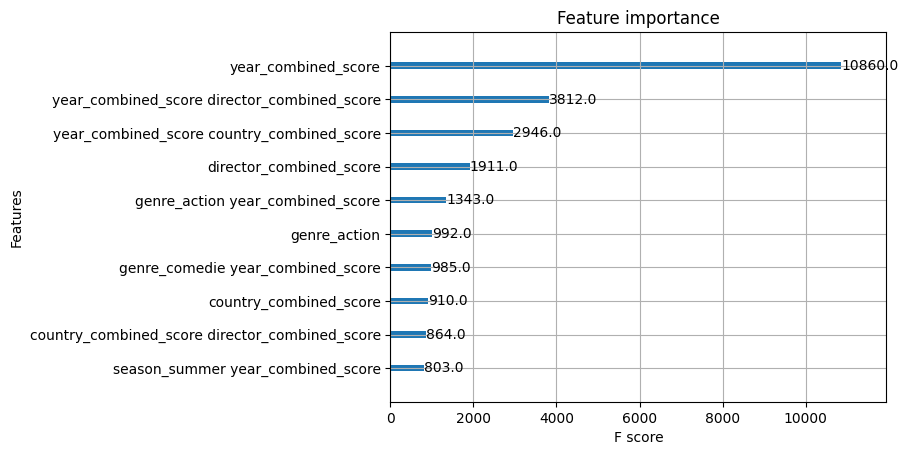

In [9]:
y_pred = model.predict(X_test)

r2_cleaned = r2_score(y_test, y_pred)
mse_cleaned = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_cleaned = np.sqrt(mse_cleaned)

print("Performance du modèle :")
# print(model.best_params_)
print(f"R2 Score: {r2_cleaned:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse_cleaned:.2f}")

xgboost.plot_importance(model[-1], max_num_features=10)

# gridSearch

In [70]:
# parameters = {
#                 'model__nthread':[1],
#                 'model__objective':['reg:squarederror''],
#                 'model__learning_rate': [.01], #so called `eta` value
#                 'model__max_depth': [7],
#                 'model__min_child_weight': [6],
#                 'model__subsample': [0.7],
#                 'model__colsample_bytree': [0.7],
#                 'model__n_estimators': [1000],
#                 'model__booster': ['gbtree']
#               }

# linear
parameters = {
                'model__nthread':[3],
                'model__objective':['reg:tweedie'],
                'model__tweedie_variance_power':[1.15],
                'model__eta': [.0004], #so called `eta` value
                'model__learning_rate': [1], #so called `eta` value
                'model__n_estimators': [4000],
                'model__booster': ['gblinear'],
                'model__eval_metric': ['rmsle']
              }

model_gs = Pipeline(steps=[
  ('transform', Pipeline(steps= [
                          ('drop', drop_after_converter_pipeline),
                          ('ohe', ohe_transformer),
                          #('poly', PolynomialFeatures(2)),
                          ('scaler', RobustScaler(with_centering=False)),
                        ])),
  ('model', xgboost.XGBRegressor())
])
model_grid = GridSearchCV(model_gs,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        error_score='raise',
                        scoring='r2',
                        verbose=True)
# model_grid.get_params().keys()
model_grid.fit(X_train, y_train)

print(model_grid.best_score_)
print(model_grid.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
0.3563138002791383
{'model__booster': 'gblinear', 'model__eta': 0.0004, 'model__eval_metric': 'rmsle', 'model__learning_rate': 1, 'model__n_estimators': 4000, 'model__nthread': 3, 'model__objective': 'reg:tweedie', 'model__tweedie_variance_power': 1.15}


Performance du modèle :
R2 Score: 0.4362
MAE: 189365.43
RMSE: 308493.49


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

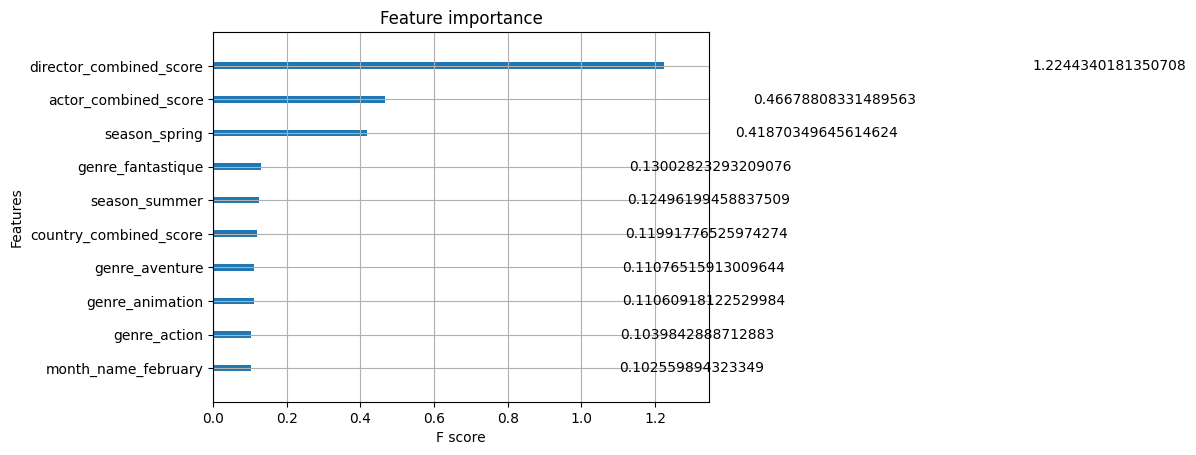

In [56]:
y_pred = model_grid.predict(X_test)

r2_cleaned = r2_score(y_test, y_pred)
mse_cleaned = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_cleaned = np.sqrt(mse_cleaned)

print("Performance du modèle :")
# print(model.best_params_)
print(f"R2 Score: {r2_cleaned:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse_cleaned:.2f}")

xgboost.plot_importance(model_grid.best_estimator_[-1], max_num_features=10)

In [12]:
from joblib import dump

dump(pipe_transform, './modelisation/pipe_transform.pkl')
dump(model, './modelisation/model.pkl')

['./modelisation/model.pkl']

In [60]:
leroy = pd.DataFrame({ # 294366
    'year': [2024],
    'day': [10],
    'month': [4],
    'duration': [6120],
    'country': ['france'],
    'copies': [414],
    'genre': [['comedie']],
    'director': ['"florent bernard"'],
    'distributor': [["nolita cinema", "tf1 studio", "apollo films"]],
    'casting': [["charlotte gainsbourg", "jose garcia", "lily aubry"]],
})

sos = pd.DataFrame({ # 308185
    'year': [2024],
    'day': [10],
    'month': [4],
    'duration': [6960],
    'country': ['etatsunis'],
    'copies': [670],
    'genre': [['action']],
    'director': ['"Gil Kenan"'],
    'distributor': [["sony pictures releasing france"]],
    'casting': [["paulrudd", "dan aykroyd", "bill murray"]],
})

panda = pd.DataFrame({ # 825898
    'year': [2024],
    'day': [27],
    'month': [3],
    'duration': [5640],
    'country': ['etatsunis'],
    'copies': [696],
    'genre': [['animation']],
    'director': ['"mike mitchell"'],
    'distributor': [["universal pictures"]],
    'casting': [["jack black"]],
})

regne = pd.DataFrame({ # 224476
  'year': [2023],
    'day': [4],
    'month': [10],
    'duration': [7680],
    'country': ['france'],
    'genre': [['aventure', 'drame', 'horreur']],
    'director': ['"thomas cailley"'],
    'distributor': [["nordouest films", "studio canal", "france 2 cinema"]],
    'casting': [["romain duris", "paul kircher", "adele exarchopoulos"]],
})

argile = pd.DataFrame({ # 15574
    'year': [2024],
    'day': [24],
    'month': [1],
    'duration': [5640],
    'country': ['france'],
    'genre': [['drame', 'romantique']],
    'director': ['"anais tellenne"'],
    'distributor': [["koro films", "vagabonds films", "micro climat"]],
    'casting': [["raphael thiery", "emmanuelle devos", "mariechristine orry"]],
})

concat = pd.concat([leroy, sos, panda, regne, argile])

pred = pipe_transform.transform(panda)
# pred['distributor_combined_score'] = 0.1
# pred['actor_combined_score'] = 0.1
# pred['director_combined_score'] = 0.1
display(pred)
print('grid', model_grid.predict(pred))
print('model', model.predict(pred))

,year,day,month,duration,country,copies,genre,director,distributor,casting,actor_combined_score,year_combined_score,season,country_combined_score,month_name,is_holiday,director_combined_score,distributor_combined_score
0,2024,27,3,5640,etatsunis,696,animation,"""mike mitchell""",[universal pictures],[jack black],0.95,0.472901,spring,1.0,march,0,0.9,0.95


grid [92826.73]
model [668755.]
